# Testing DR-TD on Complex Maze
I first train DR-TD on a complex maze with an initial terminal state. Then I move the terminal state and use the Woodbury update on the trained DR to plan towards the new terminal state. I show that DR-TD, when acting greedily, reaches the new terminal state in an optimal number of steps. For comparison I use BFS to find the optimal number of steps to each new terminal state and I show that DR-TD can reach every new terminal state in the same number of steps as BFS.

In [1]:
import os
import pickle
from copy import deepcopy
from itertools import islice

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import gymnasium as gym

import gym_env
from utils import test_agent, get_transition_matrix, create_mapping_nb, woodbury
from models import LinearRL

In [2]:
# Set the random seed for NumPy
seed = 26
np.random.seed(seed)

# Save dir
save_dir = os.path.join('..', 'figures/')

In [4]:
no_goal_env = "maze-10x10-G0"
envs = ["maze-10x10-G1", "maze-10x10-G2", "maze-10x10-G3"]

In [5]:
# Hyperparams
reward = -1
alpha = 0.25
beta = 1.5
_lambda = 1.0
num_steps = 80000

In [6]:
# Transition matrix with no goal
env = gym.make(no_goal_env)
maze = env.unwrapped.maze
# Get the transition matrix of the new environment
mapping = create_mapping_nb(env.unwrapped.maze, env.unwrapped.get_walls())
T_no_goal = get_transition_matrix(env, mapping)

In [7]:
agent = LinearRL(env_name=envs[0], reward=reward, term_reward=reward, _lambda=_lambda, beta=beta, alpha=alpha, num_steps=num_steps, policy="softmax", imp_samp=True)

In [8]:
agent.r

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 10])

In [9]:
agent.target_locs[0][0]

9

In [10]:
D_inv = agent.get_D_inv()

In [11]:
agent.learn(seed=seed)
D_td = agent.DR

In [12]:
D0_inv = np.linalg.inv(np.diag(np.exp(-agent.r)) - agent.T)
print(np.max(np.abs(agent.gamma * D_inv - D0_inv)), np.mean(np.abs(agent.gamma * D_inv - D0_inv)))
print(np.max(np.abs(D_td - D_inv)), np.mean(np.abs(D_td - D_inv)))
print(np.max(np.abs(agent.gamma * D_td - D0_inv)), np.mean(np.abs(agent.gamma * D_td - D0_inv)))

1.5820221088603361 0.0004784163388966709
1.3841431287666568 0.009310722245045639
1.5820221088603361 0.0038827509144837534


In [13]:
print(D0_inv[67][67], agent.gamma * D_inv[67][67])

-1.0000454019910097 0.5819767068693265


### Find optimal path by reusing Original DR

In [14]:
num_steps_DR_TD = {}

# Get an iterator for the dictionary
dict_iter = iter(mapping.items())
next(dict_iter)

# Iterate through the remaining key-value pairs
for loc, idx in islice(dict_iter, len(mapping) - 2):
    print(loc)
    # New agent for testing (copy of original agent)
    new_agent = deepcopy(agent)

    # Construct a new transition matrix and new environment
    T_new = np.copy(T_no_goal)
    T_new[idx] = 0
    T_new[idx, idx] = 1
    env_new = env
    env_new.unwrapped.target_locs = [np.array((loc[0], loc[1]))]
    new_agent.env = env_new

    # Use Woodbury to get a new DR
    D = woodbury(new_agent, T_new, inv=False)

    # Update new_agent terminals and target loc
    new_agent.terminals = np.diag(T_new) == 1
    new_agent.target_locs = np.array([list(loc)])

    # Update reward and P
    new_agent.r[new_agent.terminals] = 20
    new_agent.expr_t = np.exp(new_agent.r[new_agent.terminals] / new_agent._lambda)
    new_agent.P = T_new[~new_agent.terminals][:,new_agent.terminals]

    # Calculate values
    Z_values, V_values = np.zeros(new_agent.size), np.zeros(new_agent.size)
    Z_values[~new_agent.terminals] = D[~new_agent.terminals][:,~new_agent.terminals] @ new_agent.P @ new_agent.expr_t
    Z_values[new_agent.terminals] = new_agent.expr_t

    V_values = np.log(Z_values)
    new_agent.V = V_values
    
    traj = test_agent(new_agent)
    print(f"Goal at location: {loc} | Number of steps: {len(traj)}")
    num_steps_DR_TD[loc] = len(traj)

(0, 1)
c:  (68, 2)
a:  (2, 2)
d:  (2, 68)
Goal at location: (0, 1) | Number of steps: 1
(0, 2)
c:  (68, 2)
a:  (2, 2)
d:  (2, 68)
Goal at location: (0, 2) | Number of steps: 2
(0, 4)
c:  (68, 2)
a:  (2, 2)
d:  (2, 68)
Goal at location: (0, 4) | Number of steps: 8
(0, 7)
c:  (68, 2)
a:  (2, 2)
d:  (2, 68)
Goal at location: (0, 7) | Number of steps: 21
(0, 8)
c:  (68, 2)
a:  (2, 2)
d:  (2, 68)
Goal at location: (0, 8) | Number of steps: 20
(0, 9)
c:  (68, 2)
a:  (2, 2)
d:  (2, 68)
Goal at location: (0, 9) | Number of steps: 21
(1, 0)
c:  (68, 2)
a:  (2, 2)
d:  (2, 68)
Goal at location: (1, 0) | Number of steps: 1
(1, 1)
c:  (68, 2)
a:  (2, 2)
d:  (2, 68)
Goal at location: (1, 1) | Number of steps: 2
(1, 2)
c:  (68, 2)
a:  (2, 2)
d:  (2, 68)
Goal at location: (1, 2) | Number of steps: 3
(1, 4)
c:  (68, 2)
a:  (2, 2)
d:  (2, 68)
Goal at location: (1, 4) | Number of steps: 7
(1, 6)
c:  (68, 2)
a:  (2, 2)
d:  (2, 68)
Goal at location: (1, 6) | Number of steps: 21
(1, 7)
c:  (68, 2)
a:  (2, 2

In [15]:
# Save the dictionary to a file
# pickle.dump(num_steps_DR_TD, open('../out/num_steps_DR_TD_v2.pkl', 'wb'))

### BFS Approach for finding the optimal path

In [16]:
from collections import deque

def find_optimal_path(maze, start, end):
    visited = set()
    queue = deque([(tuple(start), [start])])

    while queue:
        current, path = queue.popleft()
        if np.array_equal(current, end):
            return path

        if current in visited:
            continue

        visited.add(current)

        for successor in env.unwrapped.get_successor_states(current):
            neighbor = successor[0]
            if tuple(neighbor) not in visited:
                queue.append((tuple(neighbor), path + [neighbor]))

    return None

### Find optimal path via exhaustive search

In [17]:
num_steps_exhaustive = {}

# Get an iterator for the dictionary
dict_iter = iter(mapping.items())
next(dict_iter)

# Original starting location
start_loc = agent.start_loc

# Iterate through the remaining key-value pairs
for loc, idx in islice(dict_iter, len(mapping) - 2):
    # New end location
    target_loc = np.array((loc[0], loc[1]))

    # New agent for testing (copy of original agent)
    new_agent = deepcopy(agent)

    # Construct a new transition matrix and new environment
    T_new = np.copy(T_no_goal)
    T_new[idx, idx] = 1
    env_new = env
    env_new.unwrapped.target_locs = [target_loc]

    # Find the optimal path
    path = find_optimal_path(env_new, start=start_loc, end=target_loc)
    if path is not None:
        print(f"Goal at location: {loc} | Number of steps: {len(path)-1}")
        num_steps_exhaustive[loc] = len(path) - 1
    

Goal at location: (0, 1) | Number of steps: 1
Goal at location: (0, 2) | Number of steps: 2
Goal at location: (0, 4) | Number of steps: 8
Goal at location: (0, 7) | Number of steps: 21
Goal at location: (0, 8) | Number of steps: 20
Goal at location: (0, 9) | Number of steps: 21
Goal at location: (1, 0) | Number of steps: 1
Goal at location: (1, 1) | Number of steps: 2
Goal at location: (1, 2) | Number of steps: 3
Goal at location: (1, 4) | Number of steps: 7
Goal at location: (1, 6) | Number of steps: 21
Goal at location: (1, 7) | Number of steps: 20
Goal at location: (1, 8) | Number of steps: 19
Goal at location: (1, 9) | Number of steps: 20
Goal at location: (2, 2) | Number of steps: 4
Goal at location: (2, 3) | Number of steps: 5
Goal at location: (2, 4) | Number of steps: 6
Goal at location: (2, 7) | Number of steps: 19
Goal at location: (2, 8) | Number of steps: 18
Goal at location: (2, 9) | Number of steps: 19
Goal at location: (3, 0) | Number of steps: 7
Goal at location: (3, 1)

In [18]:
# Save the dictionary to a file
# pickle.dump(num_steps_exhaustive, open('../out/num_steps_exhaustive.pkl', 'wb'))

### Plot the paths against one another

In [3]:
num_steps_DR_TD = pickle.load(open('../out/num_steps_DR_TD_v2.pkl', 'rb'))
num_steps_exhaustive = pickle.load(open('../out/num_steps_exhaustive.pkl', 'rb'))

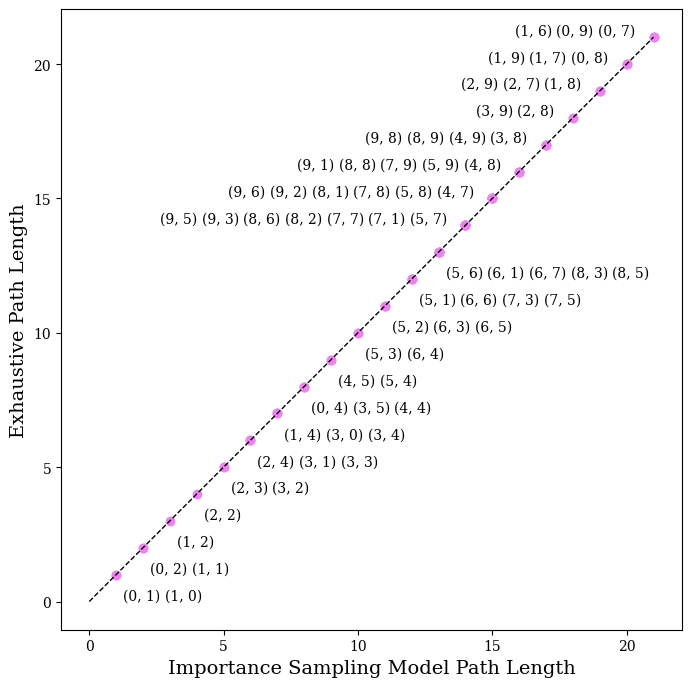

In [11]:
save_path = save_dir + 'complex_maze.png'
# save_path = None

# Extract the path lengths and target locations from the dictionaries
DR_TD_lengths = list(num_steps_DR_TD.values())
exhaustive_lengths = list(num_steps_exhaustive.values())
target_locations = list(num_steps_DR_TD.keys())

# Create a figure and axis
fig, ax = plt.subplots(figsize=(7, 7))

# Set the font to serif
plt.rcParams['font.family'] = 'serif'

# Plot the path lengths as scatter points with violet color
ax.scatter(DR_TD_lengths, exhaustive_lengths, color='violet')

# Add labels for points with length < 14
label_positions = {}
for i, location in enumerate(target_locations):
    x, y = DR_TD_lengths[i], exhaustive_lengths[i]
    if x < 14 and y < 14:
        if (x, y) not in label_positions:
            label_positions[(x, y)] = [(5, -10)]
        else:
            prev_x, prev_y = label_positions[(x, y)][-1]
            label_positions[(x, y)].append((prev_x + 30, prev_y))  # Increase spacing between labels

        xytext = label_positions[(x, y)][-1]
        ax.annotate(f"({location[0]}, {location[1]})", (x, y),
                    textcoords="offset points", xytext=xytext, ha='left', va='top')
    elif x >= 14 and y >=14:
        if (x, y) not in label_positions:
            label_positions[(x, y)] = [(-40, +10)]
        else:
            prev_x, prev_y = label_positions[(x, y)][-1]
            label_positions[(x, y)].append((prev_x - 30, prev_y))  # Increase spacing between labels

        xytext = label_positions[(x, y)][-1]
        ax.annotate(f"({location[0]}, {location[1]})", (x, y),
                    textcoords="offset points", xytext=xytext, ha='left', va='top')

# Set the labels and title for the plot
ax.set_xlabel('Importance Sampling Model Path Length', fontsize=14)
ax.set_ylabel('Exhaustive Path Length', fontsize=14)

# Add a diagonal line representing equal path lengths
max_length = max(max(DR_TD_lengths), max(exhaustive_lengths))
ax.plot([0, max_length], [0, max_length], 'k--', linewidth=1)

# Set equal scales for both axes
ax.set_aspect('equal')

if save_path is not None:
    plt.savefig(save_path, bbox_inches='tight', dpi=300)

# Display the plot
plt.tight_layout()
plt.show()